# Sesión 11:  ALGORITMOS GENÉTICOS Y EVOLUCIÓN DE LA POBLACIÓN
Realizado por:

**- Ruelas Flores, César Diego**

### VARIABLES GLOBALES

In [ ]:
# !pip install polars numpy scikit-learn deap matplotlib

In [ ]:
# las variables globales se definirán en proceso de creación del lab
URL = "https://raw.githubusercontent.com/AzShet/Data_Mining-LAB11/refs/heads/develop/Advertising-1.csv"
COLUMNAS = ["TV", "Radio", "Newspaper"]

import polars as pl # importante, no se usa pandas, sino polars
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt

## FUNCIONES DE UTILIDAD

In [4]:
%%writefile utils.py
"""
Funciones reutilizables para el proyecto de análisis de datos de publicidad con algoritmos genéticos.

Autor: César Diego Ruelas Flores
Fecha: 28-may-2025
"""
import polars as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt

def cargar_datos(url):
    """Carga los datos desde una URL y devuelve un DataFrame de Polars."""
    return pl.read_csv(url)

def tratar_outliers_iqr(df, columnas=None):
    """Elimina outliers utilizando el método del rango intercuartílico (IQR)."""
    if columnas is None:
        columnas = df.columns

    df_tratado = df.clone()
    for col in columnas:
        if df[col].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32]:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR
            mediana = df[col].median()

            df_tratado = df_tratado.with_columns(
                pl.when((pl.col(col) < limite_inferior) | (pl.col(col) > limite_superior))
                .then(mediana)
                .otherwise(pl.col(col))
                .alias(col)
            )
    return df_tratado

def escalar_datos(df, columnas=None, metodo='minmax'):
    """Escala los datos usando MinMaxScaler o StandardScaler."""
    if columnas is None:
        columnas = df.columns

    df_escalado = df.clone()

    if metodo == 'minmax':
        for col in columnas:
            if df[col].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32]:
                min_val = df[col].min()
                max_val = df[col].max()
                df_escalado = df_escalado.with_columns(
                    ((pl.col(col) - min_val) / (max_val - min_val)).alias(col)
                )

    return df_escalado

def separar_variables(df, variable_objetivo):
    """Separa las variables predictoras de la variable objetivo."""
    X = df.drop(variable_objetivo)
    y = df.select(variable_objetivo)
    return X, y

def convertir_a_numpy(df):
    """Convierte un DataFrame de Polars a array de numpy."""
    return df.to_numpy()

def crear_fitness_function(X, y):
    """Crea la función de fitness para el algoritmo genético."""
    def evaluar_individuo(individual):
        selected_features = [i for i, bit in enumerate(individual) if bit == 1]

        if len(selected_features) == 0:
            return (0.0,)  # Si no hay características seleccionadas, fitness = 0

        X_selected = X[:, selected_features]

        modelo = LinearRegression()
        scores = cross_val_score(modelo, X_selected, y.ravel(), cv=5, scoring='r2')

        return (np.mean(scores),)

    return evaluar_individuo

def configurar_algoritmo_genetico(n_features):
    """Configura el algoritmo genético usando DEAP."""
    if hasattr(creator, "FitnessMax"):
        del creator.FitnessMax
    if hasattr(creator, "Individual"):
        del creator.Individual

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, 
                     toolbox.attr_bool, n=n_features)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    return toolbox

def ejecutar_algoritmo_genetico(X, y, n_pop=50, cx_pb=0.7, mut_pb=0.2, n_gen=50):
    """Ejecuta el algoritmo genético para selección de características."""
    n_features = X.shape[1]

    toolbox = configurar_algoritmo_genetico(n_features)

    fitness_func = crear_fitness_function(X, y)
    toolbox.register("evaluate", fitness_func)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    pop = toolbox.population(n=n_pop)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)
    stats.register("min", np.min)

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=cx_pb, mutpb=mut_pb, 
                                       ngen=n_gen, stats=stats, verbose=True)

    return pop, logbook

def obtener_mejor_individuo(population):
    """Obtiene el mejor individuo de la población."""
    return tools.selBest(population, k=1)[0]

def entrenar_modelo_final(X, y, selected_features, test_size=0.2, random_state=42):
    """Entrena el modelo final con las características seleccionadas."""
    X_selected = X[:, selected_features]

    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y.ravel(), test_size=test_size, random_state=random_state
    )

    modelo = LinearRegression()
    modelo.fit(X_train, y_train)

    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    return modelo, r2_train, r2_test

def graficar_evolucion(logbook):
    """Grafica la evolución del algoritmo genético."""
    gen = logbook.select("gen")
    avg_fitness = logbook.select("avg")
    max_fitness = logbook.select("max")

    plt.figure(figsize=(10, 6))
    plt.plot(gen, avg_fitness, label='Promedio', linewidth=2)
    plt.plot(gen, max_fitness, label='Máximo', linewidth=2)
    plt.xlabel('Generación')
    plt.ylabel('R² Score')
    plt.title('Evolución del Coeficiente de Determinación (R²)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def mostrar_caracteristicas_seleccionadas(mejor_individuo, nombres_columnas):
    """Muestra las características seleccionadas por el algoritmo genético."""
    selected_features = [i for i, bit in enumerate(mejor_individuo) if bit == 1]
    selected_names = [nombres_columnas[i] for i in selected_features]

    print("Características seleccionadas:")
    for i, name in enumerate(selected_names):
        print(f"  {i+1}. {name}")

    return selected_features, selected_names

def analizar_outliers_multivariado(df, umbral=3):
    """Detecta outliers multivariados usando la distancia de Mahalanobis."""
    data = df.to_numpy()

    mean = np.mean(data, axis=0)
    cov = np.cov(data.T)

    try:
        inv_cov = np.linalg.inv(cov)
        mahal_dist = []

        for row in data:
            diff = row - mean
            mahal_dist.append(np.sqrt(diff.T @ inv_cov @ diff))

        mahal_dist = np.array(mahal_dist)
        outliers = mahal_dist > umbral

        return outliers, mahal_dist
    except np.linalg.LinAlgError:
        print("Error: Matriz de covarianza singular. No se pueden detectar outliers multivariados.")
        return np.zeros(len(data), dtype=bool), np.zeros(len(data))

def probar_multiples_configuraciones(X, y, configuraciones):
    """Prueba múltiples configuraciones del algoritmo genético."""
    resultados = []

    for i, config in enumerate(configuraciones):
        print(f"\nProbando configuración {i+1}/{len(configuraciones)}")
        print(f"N_POP: {config['n_pop']}, CX_PB: {config['cx_pb']}, MUT_PB: {config['mut_pb']}, N_GEN: {config['n_gen']}")

        pop, logbook = ejecutar_algoritmo_genetico(
            X, y, 
            n_pop=config['n_pop'],
            cx_pb=config['cx_pb'],
            mut_pb=config['mut_pb'],
            n_gen=config['n_gen']
        )

        mejor_individuo = obtener_mejor_individuo(pop)
        mejor_fitness = mejor_individuo.fitness.values[0]

        resultados.append({
            'configuracion': config,
            'mejor_fitness': mejor_fitness,
            'mejor_individuo': mejor_individuo,
            'logbook': logbook
        })

    return resultados

Overwriting utils.py


Utilizando mis funciones.

In [5]:
from utils import *

## Parte A: Preprocesamiento de la Información

**1. Información básica del dataset:**

En este apartado, obtenemos la información del dataset como la forma, las columnas y las primeras filas.

In [6]:
df = cargar_datos(URL)
print(f"   - Forma del dataset: {df.shape}")
print(f"   - Columnas: {df.columns}")
print(f"   - Primeras 5 filas:")
print(df.head())

   - Forma del dataset: (200, 4)
   - Columnas: ['TV', 'Radio', 'Newspaper', 'Sales']
   - Primeras 5 filas:
shape: (5, 4)
┌───────┬───────┬───────────┬───────┐
│ TV    ┆ Radio ┆ Newspaper ┆ Sales │
│ ---   ┆ ---   ┆ ---       ┆ ---   │
│ f64   ┆ f64   ┆ f64       ┆ f64   │
╞═══════╪═══════╪═══════════╪═══════╡
│ 230.1 ┆ 37.8  ┆ 69.2      ┆ 22.1  │
│ 44.5  ┆ 39.3  ┆ 45.1      ┆ 10.4  │
│ 17.2  ┆ 45.9  ┆ 69.3      ┆ 9.3   │
│ 151.5 ┆ 41.3  ┆ 58.5      ┆ 18.5  │
│ 180.8 ┆ 10.8  ┆ 58.4      ┆ 12.9  │
└───────┴───────┴───────────┴───────┘


**2. Análisis de datos faltantes:**

In [7]:
datos_faltantes = df.null_count()
print(datos_faltantes)

shape: (1, 4)
┌─────┬───────┬───────────┬───────┐
│ TV  ┆ Radio ┆ Newspaper ┆ Sales │
│ --- ┆ ---   ┆ ---       ┆ ---   │
│ u32 ┆ u32   ┆ u32       ┆ u32   │
╞═════╪═══════╪═══════════╪═══════╡
│ 0   ┆ 0     ┆ 0         ┆ 0     │
└─────┴───────┴───────────┴───────┘


In [8]:
df_limpio = df

**3. Dataset después de eliminar NaN:**

In [9]:
print(df_limpio.shape)

(200, 4)


**4. Estadísticas descriptivas:**

In [10]:
print(df_limpio.describe())

shape: (9, 5)
┌────────────┬───────────┬───────────┬───────────┬──────────┐
│ statistic  ┆ TV        ┆ Radio     ┆ Newspaper ┆ Sales    │
│ ---        ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ str        ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞════════════╪═══════════╪═══════════╪═══════════╪══════════╡
│ count      ┆ 200.0     ┆ 200.0     ┆ 200.0     ┆ 200.0    │
│ null_count ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ mean       ┆ 147.0425  ┆ 23.264    ┆ 30.554    ┆ 14.0225  │
│ std        ┆ 85.854236 ┆ 14.846809 ┆ 21.778621 ┆ 5.217457 │
│ min        ┆ 0.7       ┆ 0.0       ┆ 0.3       ┆ 1.6      │
│ 25%        ┆ 74.7      ┆ 10.0      ┆ 12.8      ┆ 10.4     │
│ 50%        ┆ 149.8     ┆ 23.3      ┆ 25.9      ┆ 12.9     │
│ 75%        ┆ 218.5     ┆ 36.5      ┆ 45.1      ┆ 17.4     │
│ max        ┆ 296.4     ┆ 49.6      ┆ 114.0     ┆ 27.0     │
└────────────┴───────────┴───────────┴───────────┴──────────┘


**5. Análisis de outliers univariados:**

In [11]:
for col in df_limpio.columns:
    Q1 = df_limpio[col].quantile(0.25)
    Q3 = df_limpio[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    outliers = df_limpio.filter(
        (pl.col(col) < limite_inferior) | (pl.col(col) > limite_superior)
    ).shape[0]
    
    print(f"   - {col}: {outliers} outliers detectados")
    
df_sin_outliers = tratar_outliers_iqr(df_limpio)

   - TV: 0 outliers detectados
   - Radio: 0 outliers detectados
   - Newspaper: 2 outliers detectados
   - Sales: 0 outliers detectados


**6. Dataset después del tratamiento de outliers:**

In [12]:
outliers_multi, distancias = analizar_outliers_multivariado(df_sin_outliers)

**7. Análisis de outliers multivariados:**

In [13]:
print(f"   - Outliers multivariados detectados: {np.sum(outliers_multi)}")


   - Outliers multivariados detectados: 9


**8. Escalamiento de datos:**

In [14]:
df_escalado = escalar_datos(df_sin_outliers)
print("   - Datos escalados usando MinMaxScaler")
print("   - Estadísticas después del escalamiento:")
print(df_escalado.describe())

   - Datos escalados usando MinMaxScaler
   - Estadísticas después del escalamiento:
shape: (9, 5)
┌────────────┬──────────┬──────────┬───────────┬──────────┐
│ statistic  ┆ TV       ┆ Radio    ┆ Newspaper ┆ Sales    │
│ ---        ┆ ---      ┆ ---      ┆ ---       ┆ ---      │
│ str        ┆ f64      ┆ f64      ┆ f64       ┆ f64      │
╞════════════╪══════════╪══════════╪═══════════╪══════════╡
│ count      ┆ 200.0    ┆ 200.0    ┆ 200.0     ┆ 200.0    │
│ null_count ┆ 0.0      ┆ 0.0      ┆ 0.0       ┆ 0.0      │
│ mean       ┆ 0.494902 ┆ 0.469032 ┆ 0.330382  ┆ 0.489075 │
│ std        ┆ 0.290342 ┆ 0.299331 ┆ 0.228364  ┆ 0.205412 │
│ min        ┆ 0.0      ┆ 0.0      ┆ 0.0       ┆ 0.0      │
│ 25%        ┆ 0.250254 ┆ 0.201613 ┆ 0.140292  ┆ 0.346457 │
│ 50%        ┆ 0.504227 ┆ 0.469758 ┆ 0.285634  ┆ 0.444882 │
│ 75%        ┆ 0.736557 ┆ 0.735887 ┆ 0.482604  ┆ 0.622047 │
│ max        ┆ 1.0      ┆ 1.0      ┆ 1.0       ┆ 1.0      │
└────────────┴──────────┴──────────┴───────────┴──────────┘


## Parte B: Algoritmo Genético para selección de características

**9. Variables separadas:**

In [15]:
X_df, y_df = separar_variables(df_escalado, 'Sales')
print(f"   - Características (X): {X_df.shape}")
print(f"   - Variable objetivo (y): {y_df.shape}")

X = convertir_a_numpy(X_df)
y = convertir_a_numpy(y_df)
nombres_caracteristicas = X_df.columns

   - Características (X): (200, 3)
   - Variable objetivo (y): (200, 1)


**10. Conversión a numpy arrays completada**

In [17]:
print(f"    - X shape: {X.shape}")
print(f"    - y shape: {y.shape}")

configuraciones = [
    {'n_pop': 30, 'cx_pb': 0.6, 'mut_pb': 0.1, 'n_gen': 30},
    {'n_pop': 50, 'cx_pb': 0.7, 'mut_pb': 0.2, 'n_gen': 40},
    {'n_pop': 70, 'cx_pb': 0.8, 'mut_pb': 0.3, 'n_gen': 50},
    {'n_pop': 100, 'cx_pb': 0.9, 'mut_pb': 0.1, 'n_gen': 60}
]

    - X shape: (200, 3)
    - y shape: (200, 1)


In [18]:
print(f"\n11. Probando {len(configuraciones)} configuraciones diferentes:")

resultados = probar_multiples_configuraciones(X, y, configuraciones)

mejor_config_idx = np.argmax([r['mejor_fitness'] for r in resultados])
mejor_resultado = resultados[mejor_config_idx]


11. Probando 4 configuraciones diferentes:

Probando configuración 1/4
N_POP: 30, CX_PB: 0.6, MUT_PB: 0.1, N_GEN: 30
gen	nevals	avg     	max     	min
0  	30    	0.456417	0.889283	0  
1  	15    	0.775198	0.889283	0.289392
2  	19    	0.870512	0.889283	0.5926  
3  	22    	0.889283	0.889283	0.889283
4  	23    	0.889283	0.889283	0.889283
5  	23    	0.889283	0.889283	0.889283
6  	15    	0.889283	0.889283	0.889283
7  	20    	0.889283	0.889283	0.889283
8  	16    	0.889283	0.889283	0.889283
9  	19    	0.889283	0.889283	0.889283
10 	25    	0.889283	0.889283	0.889283
11 	20    	0.889212	0.889283	0.887142
12 	20    	0.889283	0.889283	0.889283
13 	22    	0.889283	0.889283	0.889283
14 	21    	0.889283	0.889283	0.889283
15 	13    	0.889283	0.889283	0.889283
16 	12    	0.889283	0.889283	0.889283
17 	19    	0.889283	0.889283	0.889283
18 	17    	0.889212	0.889283	0.887142
19 	17    	0.869992	0.889283	0.310564
20 	19    	0.889283	0.889283	0.889283
21 	22    	0.869921	0.889283	0.310564
22 	15    	0.88928

**12. Mejor configuración encontrada:**

In [19]:
print(f"    - Índice: {mejor_config_idx + 1}")
print(f"    - Configuración: {mejor_resultado['configuracion']}")
print(f"    - Mejor fitness (R²): {mejor_resultado['mejor_fitness']:.4f}")

    - Índice: 1
    - Configuración: {'n_pop': 30, 'cx_pb': 0.6, 'mut_pb': 0.1, 'n_gen': 30}
    - Mejor fitness (R²): 0.8893


## Parte C: Modelo de regresión lineal

In [20]:
mejor_individuo = mejor_resultado['mejor_individuo']
caracteristicas_seleccionadas, nombres_seleccionados = mostrar_caracteristicas_seleccionadas(
    mejor_individuo, nombres_caracteristicas
)

Características seleccionadas:
  1. TV
  2. Radio


**13. Graficando evolución del algoritmo genético:**

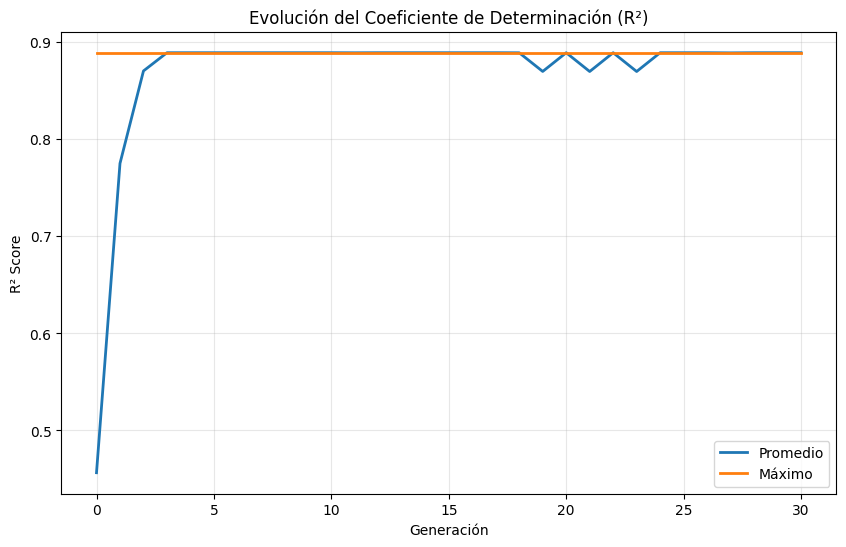

In [21]:
graficar_evolucion(mejor_resultado['logbook'])

modelo_final, r2_train, r2_test = entrenar_modelo_final(
    X, y, caracteristicas_seleccionadas, test_size=0.2, random_state=42
)

**14. Entrenando modelo final con las características seleccionadas:**

In [ ]:
print(f"    - R² en entrenamiento (80%): {r2_train:.4f}")
print(f"    - R² en prueba (20%): {r2_test:.4f}")

    - R² en entrenamiento (80%): 0.8956
    - R² en prueba (20%): 0.9006


In [23]:
modelo_completo, r2_train_completo, r2_test_completo = entrenar_modelo_final(
    X, y, list(range(X.shape[1])), test_size=0.2, random_state=42
)

**15. Comparación con modelo usando todas las características:**

In [24]:
print(f"    - R² en entrenamiento (todas las características): {r2_train_completo:.4f}")
print(f"    - R² en prueba (todas las características): {r2_test_completo:.4f}")

    - R² en entrenamiento (todas las características): 0.8957
    - R² en prueba (todas las características): 0.8999


In [25]:
print("\n" + "=" * 60)
print("RESUMEN DE RESULTADOS")
print("=" * 60)

print(f"Dataset original: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"Características originales: {len(nombres_caracteristicas)}")
print(f"Características seleccionadas: {len(caracteristicas_seleccionadas)}")
print(f"Porcentaje de reducción: {(1 - len(caracteristicas_seleccionadas)/len(nombres_caracteristicas))*100:.1f}%")


RESUMEN DE RESULTADOS
Dataset original: 200 filas, 4 columnas
Características originales: 3
Características seleccionadas: 2
Porcentaje de reducción: 33.3%


**Mejor configuración del algoritmo genético:**

In [26]:
for key, value in mejor_resultado['configuracion'].items():
    print(f"  - {key.upper()}: {value}")

  - N_POP: 30
  - CX_PB: 0.6
  - MUT_PB: 0.1
  - N_GEN: 30


**Rendimiento del modelo:**

In [27]:
print(f"  - Con características seleccionadas: R² = {r2_test:.4f}")
print(f"  - Con todas las características: R² = {r2_test_completo:.4f}")
diferencia = r2_test - r2_test_completo
if diferencia > 0:
    print(f"  - Mejora: +{diferencia:.4f}")
else:
    print(f"  - Pérdida: {diferencia:.4f}")

  - Con características seleccionadas: R² = 0.9006
  - Con todas las características: R² = 0.8999
  - Mejora: +0.0006


**Características seleccionadas:**

In [ ]:
for i, nombre in enumerate(nombres_seleccionados):
    print(f"  {i+1}. {nombre}")

  1. TV
  2. Radio


## pytest

In [29]:
%%writefile test_utils.py
import pytest
import polars as pl
import numpy as np
from sklearn.datasets import make_regression
from utils import *

# Definición de variables globales
URL = "https://raw.githubusercontent.com/AzShet/Data_Mining-LAB11/refs/heads/develop/Advertising-1.csv"
COLUMNAS = ["TV", "Radio", "Newspaper", "Sales"]

# Generar un DataFrame de prueba
def generar_dataframe_prueba():
    X, y = make_regression(n_samples=100, n_features=3, noise=0.1)
    df = pl.DataFrame({
        "TV": X[:, 0],
        "Radio": X[:, 1],
        "Newspaper": X[:, 2],
        "Sales": y
    })
    return df

def test_cargar_datos():
    df = cargar_datos(URL)
    assert df.shape[0] > 0  # Verifica que se carguen filas
    assert set(COLUMNAS).issubset(df.columns)  # Verifica que las columnas esperadas estén presentes

def test_tratar_outliers_iqr():
    df = generar_dataframe_prueba()
    df_sin_outliers = tratar_outliers_iqr(df)
    assert df_sin_outliers.shape[0] <= df.shape[0]  # Verifica que se eliminen filas

def test_escalar_datos():
    df = generar_dataframe_prueba()
    df_escalado = escalar_datos(df)
    assert (df_escalado.select(pl.all()).to_numpy().min() >= 0).all()  # Verifica que los valores estén en el rango [0, 1]
    assert (df_escalado.select(pl.all()).to_numpy().max() <= 1).all()

def test_separar_variables():
    df = generar_dataframe_prueba()
    X, y = separar_variables(df, 'Sales')
    assert X.shape[1] == 3  # Verifica que se devuelvan 3 características
    assert y.shape[1] == 1  # Verifica que se devuelva 1 variable objetivo

def test_convertir_a_numpy():
    df = generar_dataframe_prueba()
    np_array = convertir_a_numpy(df)
    assert np_array.shape == (100, 4)  # Verifica que el tamaño del array sea correcto

def test_crear_fitness_function():
    df = generar_dataframe_prueba()
    X, y = separar_variables(df, 'Sales')
    fitness_func = crear_fitness_function(X.to_numpy(), y.to_numpy())
    individual = [1, 0, 1]  # Selecciona las características 0 y 2
    fitness = fitness_func(individual)
    assert isinstance(fitness, tuple)  # Verifica que la función devuelva una tupla

def test_configurar_algoritmo_genetico():
    df = generar_dataframe_prueba()
    X, y = separar_variables(df, 'Sales')
    toolbox = configurar_algoritmo_genetico(X.shape[1])
    assert toolbox.population(10)  # Verifica que se pueda crear una población

def test_ejecutar_algoritmo_genetico():
    df = generar_dataframe_prueba()
    X, y = separar_variables(df, 'Sales')
    pop, logbook = ejecutar_algoritmo_genetico(X.to_numpy(), y.to_numpy(), n_pop=10, n_gen=5)
    assert len(pop) == 10  # Verifica que la población tenga el tamaño correcto
    assert len(logbook) == 6  # Verifica que el logbook tenga el número correcto de generaciones

def test_obtener_mejor_individuo():
    df = generar_dataframe_prueba()
    X, y = separar_variables(df, 'Sales')
    pop, _ = ejecutar_algoritmo_genetico(X.to_numpy(), y.to_numpy(), n_pop=10, n_gen=5)
    mejor_individuo = obtener_mejor_individuo(pop)
    assert mejor_individuo is not None  # Verifica que se obtenga un mejor individuo

def test_entrenar_modelo_final():
    df = generar_dataframe_prueba()
    X, y = separar_variables(df, 'Sales')
    modelo, r2_train, r2_test = entrenar_modelo_final(X.to_numpy(), y.to_numpy(), selected_features=[0, 1], test_size=0.2)
    assert modelo is not None  # Verifica que se entrene un modelo
    assert r2_train >= 0  # Verifica que el R² en entrenamiento sea no negativo
    assert r2_test >= 0  # Verifica que el R² en prueba sea no negativo

def test_graficar_evolucion():
    df = generar_dataframe_prueba()
    X, y = separar_variables(df, 'Sales')
    pop, logbook = ejecutar_algoritmo_genetico(X.to_numpy(), y.to_numpy(), n_pop=10, n_gen=5)
    try:
        graficar_evolucion(logbook)  # Verifica que no se produzca un error al graficar
    except Exception as e:
        assert False, f"Error al graficar evolución: {e}"

def test_mostrar_caracteristicas_seleccionadas():
    df = generar_dataframe_prueba()
    X, y = separar_variables(df, 'Sales')
    pop, logbook = ejecutar_algoritmo_genetico(X.to_numpy(), y.to_numpy(), n_pop=10, n_gen=5)
    mejor_individuo = obtener_mejor_individuo(pop)
    caracteristicas_seleccionadas, nombres_seleccionados = mostrar_caracteristicas_seleccionadas(mejor_individuo, COLUMNAS)
    assert len(caracteristicas_seleccionadas) <= len(COLUMNAS)  # Verifica que no se seleccionen más características de las disponibles

def test_analizar_outliers_multivariado():
    df = generar_dataframe_prueba()
    outliers, distancias = analizar_outliers_multivariado(df)
    assert len(outliers) == df.shape[0]  # Verifica que el número de outliers coincida con el número de filas

def test_probar_multiples_configuraciones():
    df = generar_dataframe_prueba()
    X, y = separar_variables(df, 'Sales')
    configuraciones = [
        {'n_pop': 10, 'cx_pb': 0.6, 'mut_pb': 0.1, 'n_gen': 5},
        {'n_pop': 20, 'cx_pb': 0.7, 'mut_pb': 0.2, 'n_gen': 10}
    ]
    resultados = probar_multiples_configuraciones(X.to_numpy(), y.to_numpy(), configuraciones)
    assert len(resultados) == len(configuraciones)  # Verifica que se devuelvan resultados para cada configuración


Overwriting test_utils.py


In [30]:
# Ejecutar pytest
!pytest test_utils.py -v

============================= test session starts =============================
platform win32 -- Python 3.13.3, pytest-8.3.5, pluggy-1.5.0 -- C:\Users\AzShet\AppData\Local\Programs\Python\Python313\python.exe
cachedir: .pytest_cache
rootdir: c:\TECSUP\5-tecsup\Mineria de Datos\Semana (11)\LAB_Ruelas\tcp-md-laboratorio11
plugins: anyio-4.9.0
collecting ... collected 14 items

test_utils.py::test_cargar_datos PASSED                                  [  7%]
test_utils.py::test_tratar_outliers_iqr PASSED                           [ 14%]
test_utils.py::test_escalar_datos PASSED                                 [ 21%]
test_utils.py::test_separar_variables PASSED                             [ 28%]
test_utils.py::test_convertir_a_numpy PASSED                             [ 35%]
test_utils.py::test_crear_fitness_function PASSED                        [ 42%]
test_utils.py::test_configurar_algoritmo_genetico PASSED                 [ 50%]
test_utils.py::test_ejecutar_algoritmo_genetico PASSED       